In [ ]:
# Core Libraries
import os
import shutil
import itertools
import random
import warnings

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Image Handling
import cv2
import imutils
from PIL import Image
from tqdm import tqdm

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential

# Layers
from tensorflow.keras.layers import (
    BatchNormalization,
    MaxPooling2D,
    Conv2D,
    Dense,
    Dropout,
    Flatten
)

# Optimizers
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax, legacy

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    array_to_img,
    load_img
)
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Download model
from tensorflow.keras.models import load_model
from google.colab import files

# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

warnings.filterwarnings("ignore")

In [ ]:
!pip install visualkeras

# Visualize model
from visualkeras import layered_view

In [ ]:
import kagglehub

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Original dataset path:", path)

# Create ./data if it doesn't exist
os.makedirs("./data", exist_ok=True)

destination = "./data/"

# Copy dataset to ./data
shutil.copytree(path, destination, dirs_exist_ok=True)

print("Dataset copied to:", destination)

Original dataset path: /kaggle/input/brain-tumor-mri-dataset
Dataset copied to: ./data/


In [ ]:
def load_data(dir_path, img_size=(128, 128)):
    """
    Load images from subfolders and resize them into NumPy arrays.
    Each subfolder inside dir_path represents a class label.
    """
    X = []
    y = []
    i = 0
    labels = dict()

    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):  # skip hidden files/folders
            labels[i] = path
            folder_path = os.path.join(dir_path, path)

            for file in os.listdir(folder_path):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(folder_path, file))
                    img = cv2.resize(img, img_size)  # resize
                    X.append(img)
                    y.append(i)
            i += 1

    X = np.array(X)
    y = np.array(y)

    print(f'{len(X)} images loaded from {dir_path}.')

    return X, y, labels

In [ ]:
def get_class_types(data_dir: str):
    """
    Loops through the given directory and returns a list of class names
    (subdirectory names inside data_dir).
    """
    class_types = [
        d for d in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, d))
    ]
    return sorted(class_types)

In [ ]:
CLASS_TYPES = get_class_types("./data/Training/")
N_TYPES = len(CLASS_TYPES)

print("Classes found:", CLASS_TYPES)
print("Number of classes:", N_TYPES)

Classes found: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of classes: 4


In [ ]:
X_train, y_train, train_labels = load_data(
    dir_path="./data/Training/",
    img_size=(150, 150)
)

100%|██████████| 4/4 [00:14<00:00,  3.54s/it]


5712 images loaded from ./data/Training/.


In [ ]:
X_test, y_test, test_labels = load_data(
    dir_path="./data/Testing/",
    img_size=(150, 150)
)

100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

1311 images loaded from ./data/Testing/.


In [ ]:
train_labels

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

In [ ]:
def plot_data_distribution(y_train, y_test, class_names):
    """
    Plots pie charts showing training data distribution,
    train-test split, and testing data distribution.
    """
    # Count samples per class
    train_counts = np.bincount(y_train)
    test_counts = np.bincount(y_test)

    # Pie chart: Training Data
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.pie(train_counts, labels=class_names, autopct=lambda p: f'{p:.2f}%\n{int(p*sum(train_counts)/100)}')
    plt.title("Training Data")

    # Pie chart: Train/Test Split
    plt.subplot(1, 3, 2)
    split_sizes = [len(y_train), len(y_test)]
    split_labels = ["Train", "Test"]
    plt.pie(split_sizes, labels=split_labels, autopct=lambda p: f'{p:.2f}%\n{int(p*sum(split_sizes)/100)}')
    plt.title("Train Test Split")

    # Pie chart: Testing Data
    plt.subplot(1, 3, 3)
    plt.pie(test_counts, labels=class_names, autopct=lambda p: f'{p:.2f}%\n{int(p*sum(test_counts)/100)}')
    plt.title("Testing Data")

    plt.show()

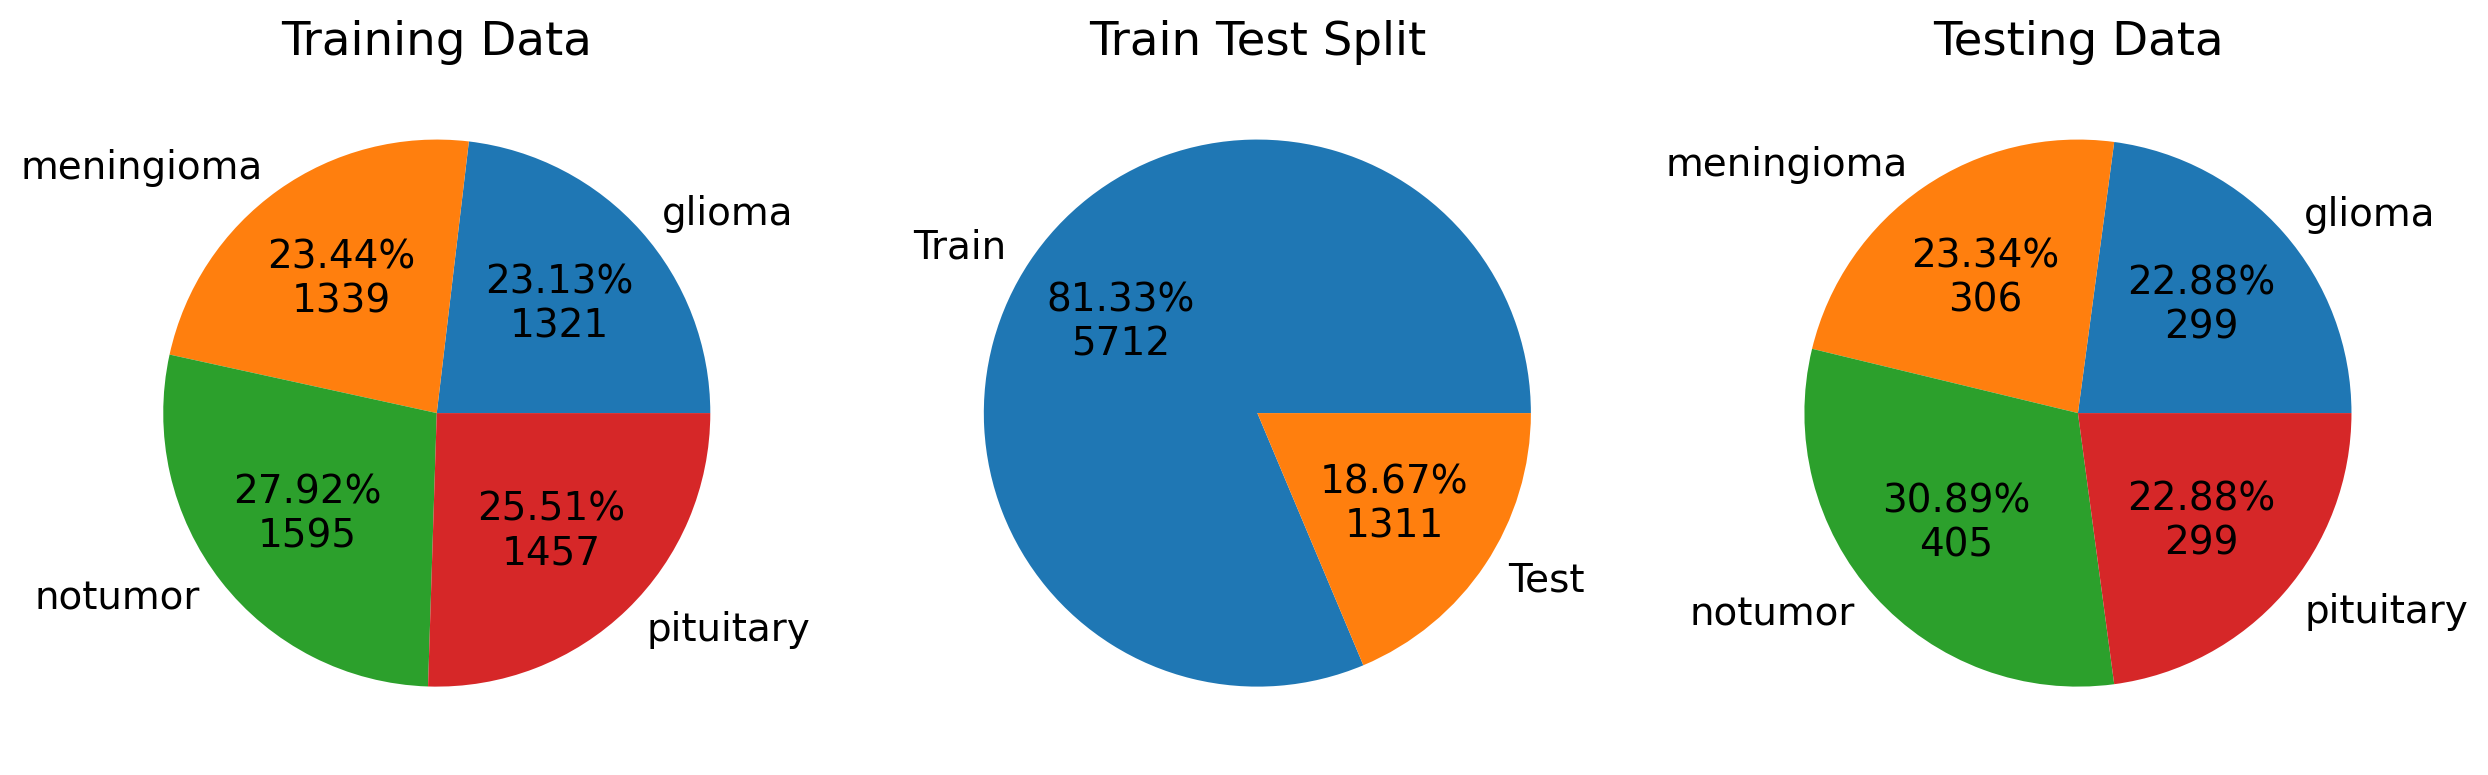

In [ ]:
plot_data_distribution(y_train, y_test, CLASS_TYPES)

Label 0


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
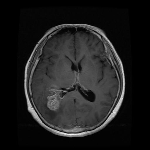

In [ ]:
print(f"Label {y_train[60]}")
X_train[200]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
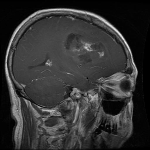

In [ ]:
X_train[488]

In [ ]:
def plot_sample_images(
    X,
    y,
    class_names=None,
    im_size=150,
    figsize=(13, 10),
    index_list=None
):
    if index_list is None:
        index_list = range(12)  # default: show first 12

    n_images = len(index_list)
    n_cols = 4
    n_rows = (n_images + n_cols - 1) // n_cols

    plt.figure(figsize=figsize)

    for i, idx in enumerate(index_list):
        plt.subplot(n_rows, n_cols, i + 1)

        # Show image
        plt.imshow(X[idx].squeeze(), cmap="gray")
        plt.axis("off")

        # Label
        label = y[idx]
        if class_names is not None and isinstance(label, (int, np.integer)):
            label = class_names[label]

        plt.title(f"{idx}: {label}", fontsize=10)

    plt.tight_layout()
    plt.show()

In [ ]:
train_labels

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

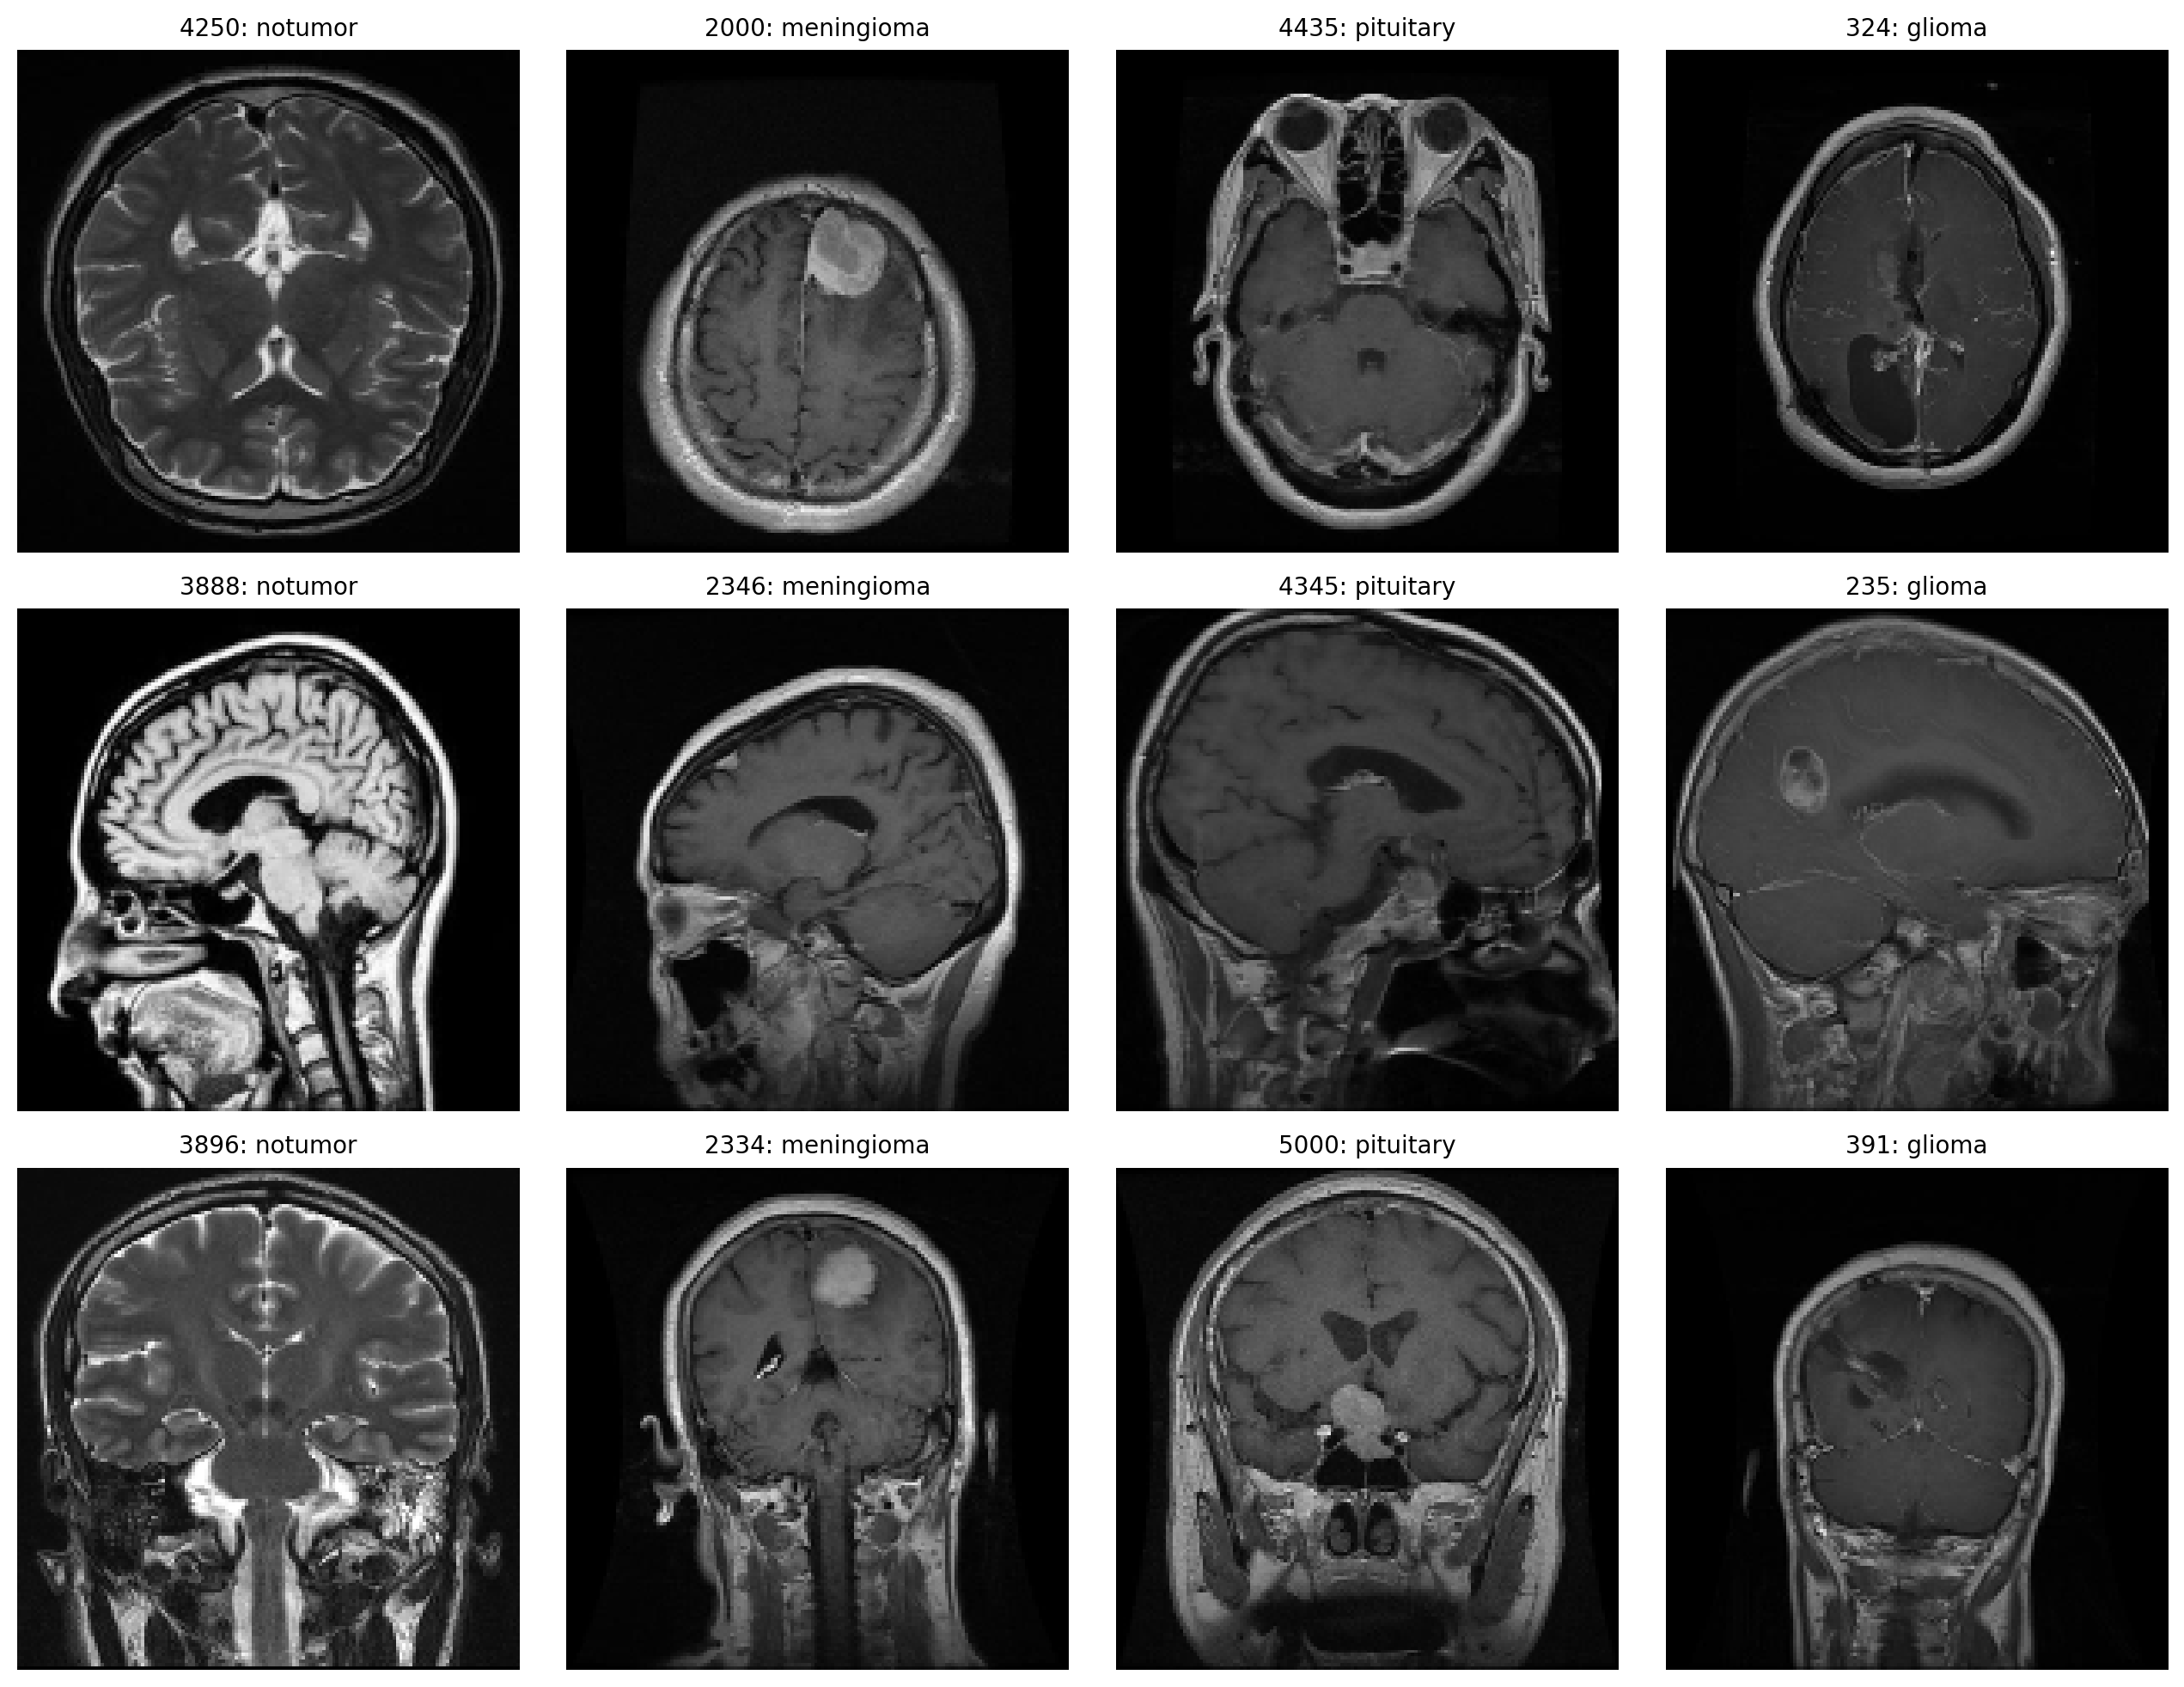

In [ ]:
plot_sample_images(
    X_train,
    y_train,
    class_names=train_labels,
    im_size=350,
    figsize=(13, 10),
    index_list=[
        4250, 2000, 4435, 324,
        3888, 2346, 4345, 235,
        3896, 2334, 5000, 391
    ]
)

## Data Augmentation

In [ ]:
batch_size = 32
image_size = (150, 150)
train_dir = "./data/Training/"
test_dir = "./data/Testing/"

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    brightness_range=(0.85, 1.15),
    width_shift_range=0.002,
    height_shift_range=0.002,
    shear_range=12.5,
    zoom_range=0,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest"
)


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=SEED
)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=SEED
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
class_indices_train_list = list(train_generator.class_indices.keys())
class_indices_train_list

['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
print(train_generator.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 40
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


## Model building

In [ ]:
# Define the model architecture
model = models.Sequential([

    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])

model.summary()

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

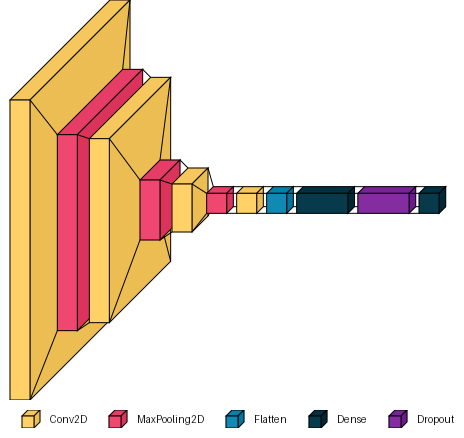

In [ ]:
layered_view(model, legend=True, max_xy=300)

In [ ]:
model.build(input_shape=(None, 150, 150, 3))

In [ ]:
EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False, start_from_epoch=0)
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

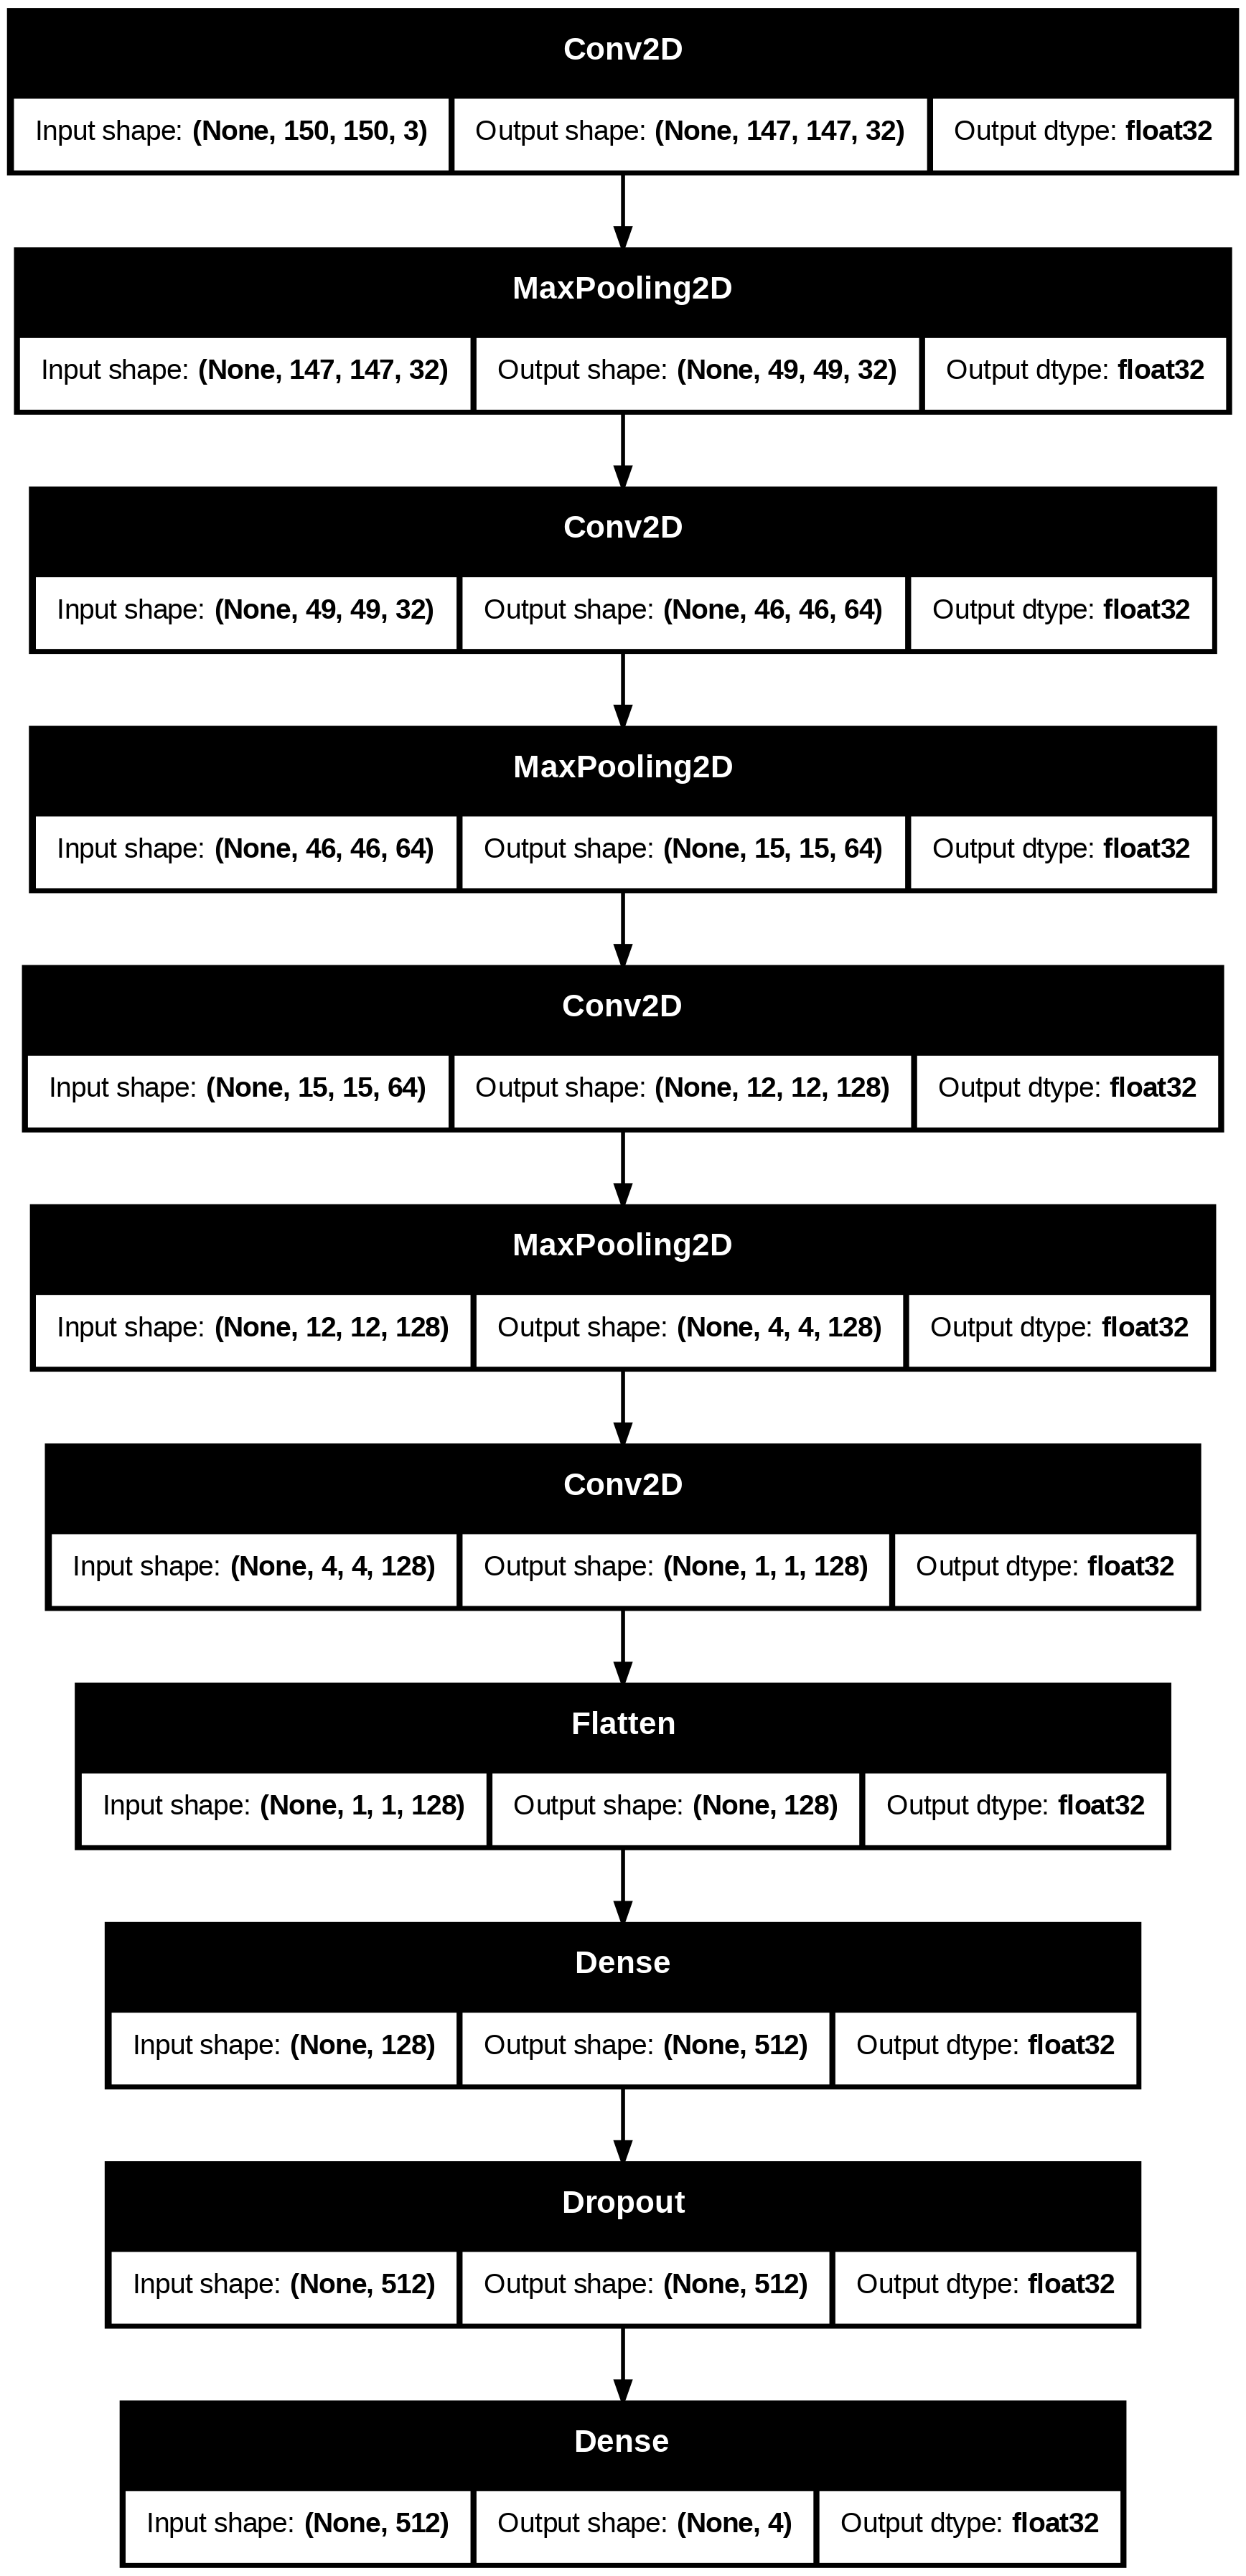

In [ ]:
# Build the model with input shape
model.build(input_shape=(None, 150, 150, 3))

# Now you can visualize
plot_model(model, show_shapes=True, show_dtype=True, to_file="model_architecture.png")

from IPython.display import Image
Image(filename="model_architecture.png")

In [ ]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[model_es, model_rlr]
)

Epoch 1/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.4783 - loss: 1.0662 - val_accuracy: 0.6953 - val_loss: 0.7063 - learning_rate: 0.0010
Epoch 2/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.8750 - loss: 0.5527 - val_accuracy: 0.6797 - val_loss: 0.7556 - learning_rate: 0.0010
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.7703 - loss: 0.5431 - val_accuracy: 0.7266 - val_loss: 0.7238 - learning_rate: 0.0010
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.6875 - loss: 0.6108 - val_accuracy: 0.7570 - val_loss: 0.6548 - learning_rate: 0.0010
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8168 - loss: 0.4516 - val_accuracy: 0.8219 - val_loss: 0.4102 - learning_rate: 0.0010
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.9062 - loss: 0.2730 - val_accuracy: 0.8078 - val_loss: 0.4372 - learning_rate: 0.0010
Epoch 7/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8626 - los

In [ ]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step - accuracy: 0.9886 - loss: 0.0543
Test Loss: 0.04962
Test Accuracy: 0.98984


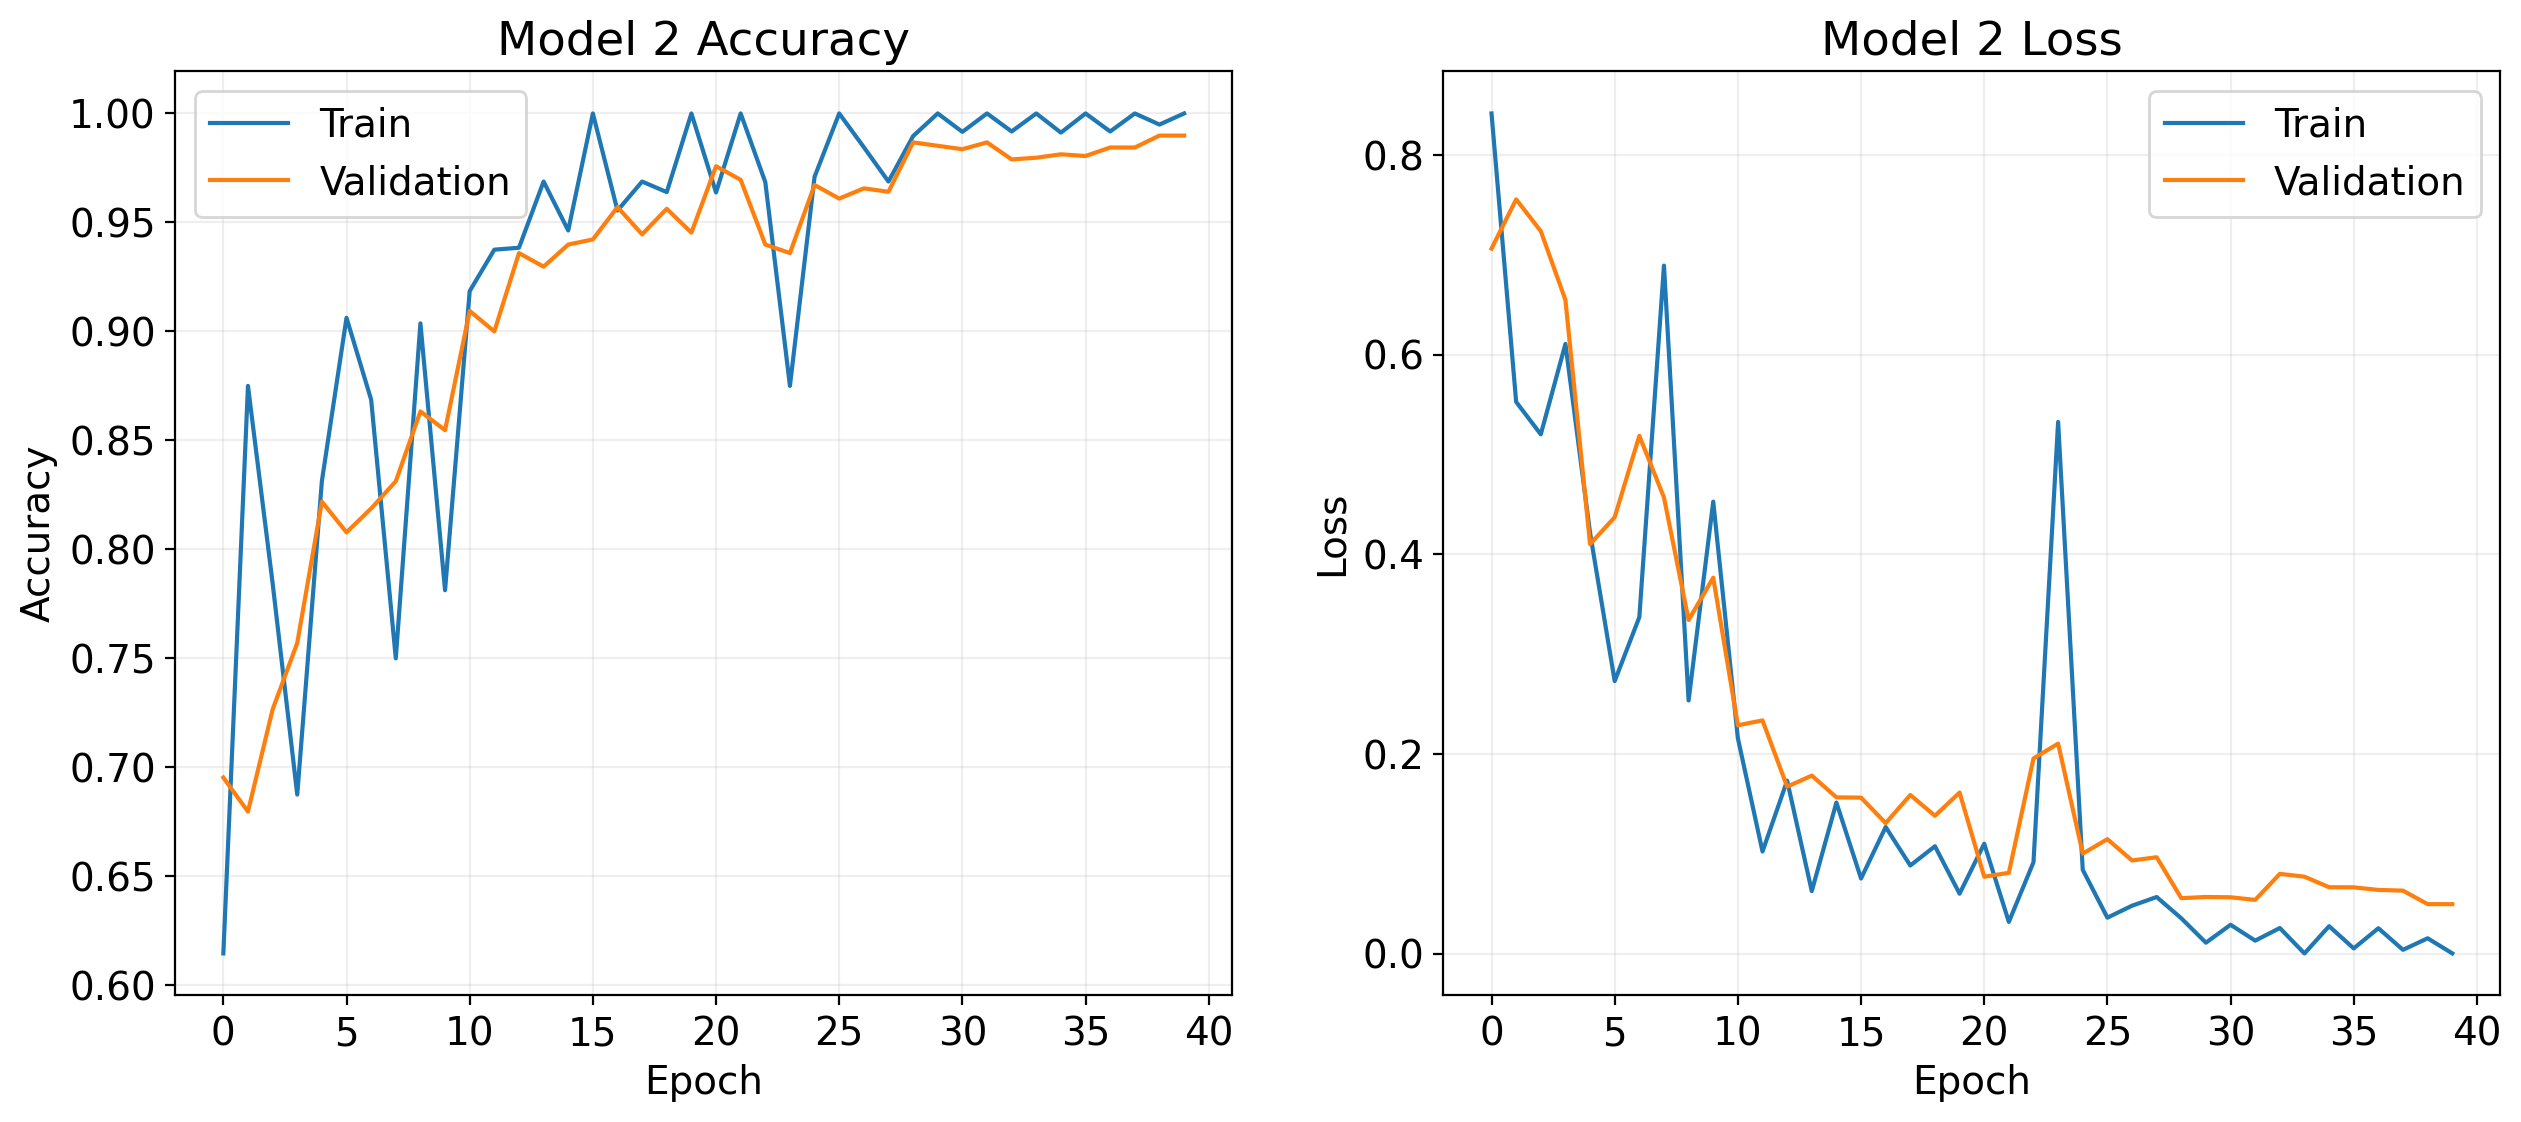

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

In [ ]:
model.save("brain_tumor_multiclass_model.keras")

In [ ]:
files.download("brain_tumor_multiclass_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def CM(CNN_model, test_generator, categories):
    # Get predictions
    predictions = CNN_model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)

    # Get true labels
    y_true = test_generator.classes

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return cm

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 288ms/step


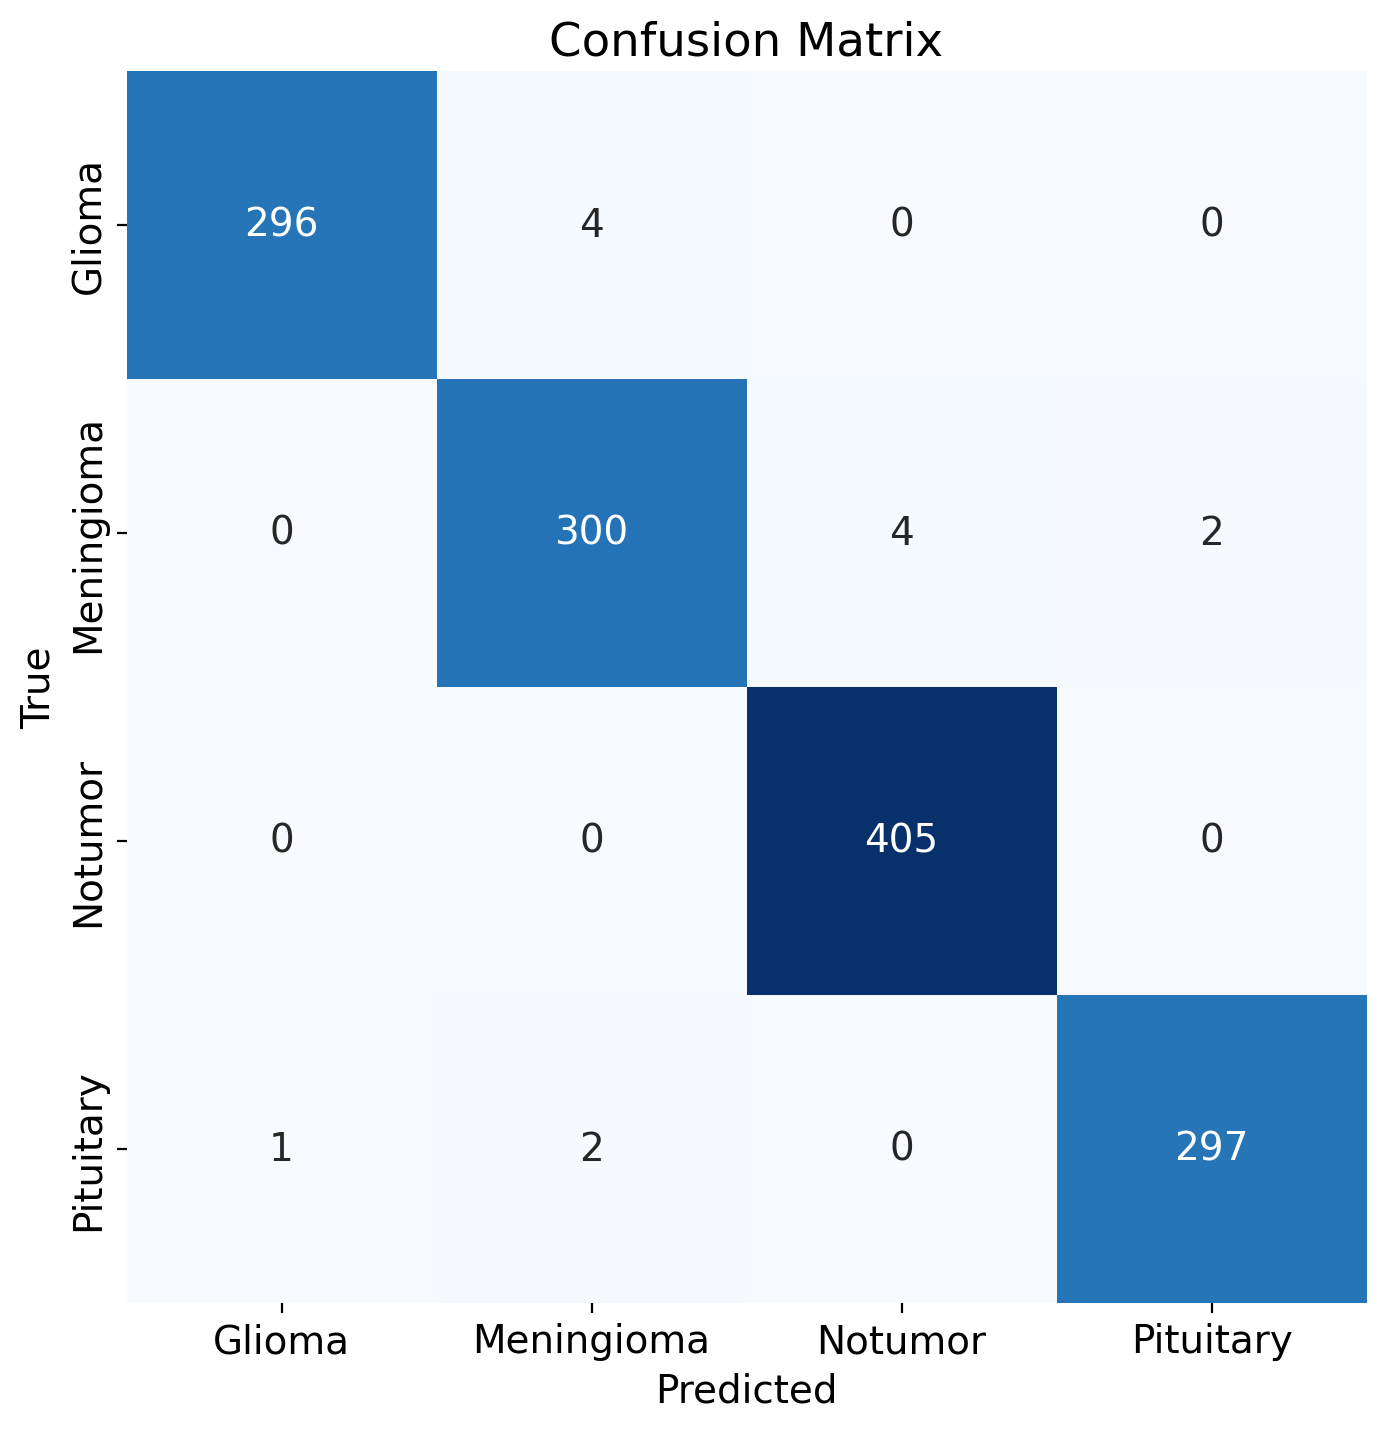

In [ ]:
# Plotting confusion matrix
confusion_matrix = CM(
    CNN_model=model,
    test_generator=test_generator,
    categories=class_indices_train_list
)

plt.figure(figsize=(8,8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(
    ticks=np.arange(N_TYPES) + 0.5,
    labels=[name.title() for name in class_indices_train_list],
    ha='center'
)
plt.yticks(
    ticks=np.arange(N_TYPES) + 0.5,
    labels=[name.title() for name in class_indices_train_list],
    va='center'
)
plt.show()

In [ ]:
def predict_only(model, img_path, target_size=(128, 128), class_names=None):
    """
    Simple prediction without Grad-CAM to avoid the architectural issue
    """
    # Load and preprocess the image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not load image from path: {img_path}")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, target_size)
    img_array = np.expand_dims(img_resized, axis=0) / 255.0

    # Make prediction
    try:
        preds = model.predict(img_array, verbose=0)
        predicted_idx = np.argmax(preds[0])
        predicted_class = class_names[predicted_idx] if class_names else predicted_idx
        confidence = preds[0][predicted_idx]
        return predicted_class, confidence, img_rgb
    except Exception as e:
        print(f"Prediction failed: {e}")
        return "Error", 0.0, img_rgb

In [ ]:
tumor_class, conf, img = predict_only(
    model, "./data/Testing/meningioma/Te-me_0010.jpg",
    target_size=(150, 150),
    class_names=class_indices_train_list
)

In [ ]:
print(tumor_class)

meningioma


array([[[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [7, 7, 7],
        [7, 7, 7],
        [7, 7, 7]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [7, 7, 7],
        [7, 7, 7],
        [7, 7, 7]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [7, 7, 7],
        [7, 7, 7],
        [7, 7, 7]],

       ...,

       [[4, 4, 4],
        [4, 4, 4],
        [5, 5, 5],
        ...,
        [5, 5, 5],
        [5, 5, 5],
        [5, 5, 5]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [5, 5, 5],
        [5, 5, 5],
        [5, 5, 5]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [5, 5, 5],
        [5, 5, 5],
        [5, 5, 5]]], dtype=uint8)
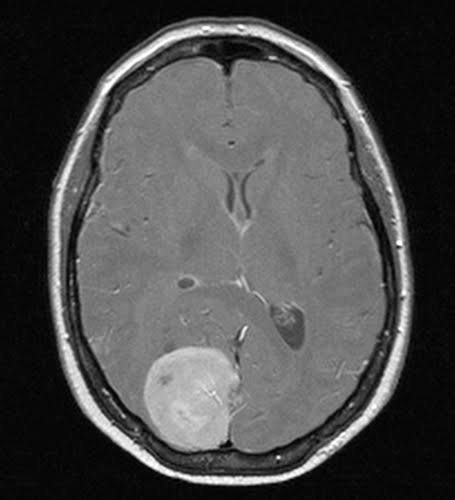

In [ ]:
img

Trying size: (150, 150)
Success! Predicted: meningioma with confidence: 1.00


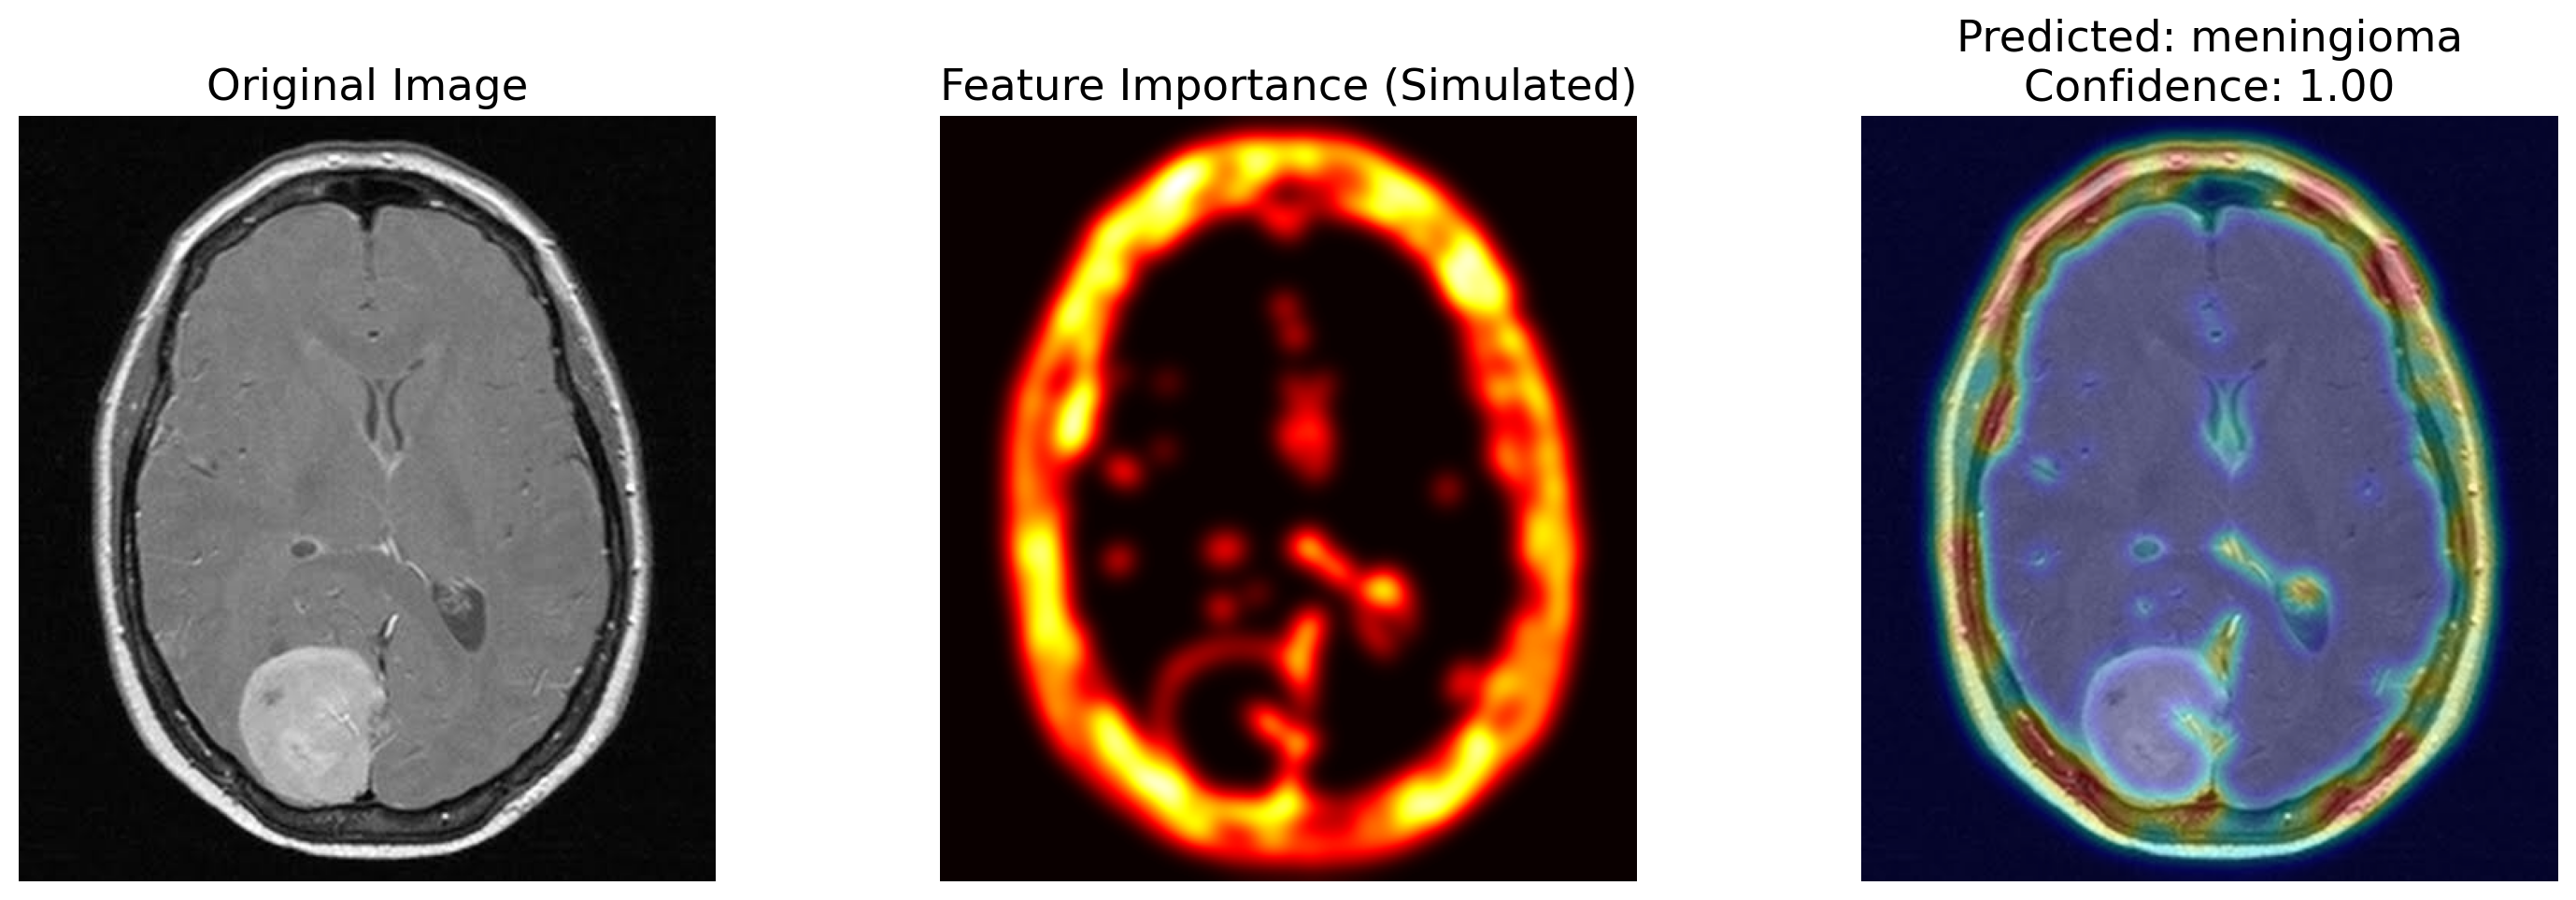

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def predict_with_custom_size(model, img_path, target_size=(256, 256), class_names=None):
    """
    Predict using your trained model with a larger input size that avoids dimension issues
    """
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not load image from path: {img_path}")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Use a larger input size that works with your architecture
    img_resized = cv2.resize(img_rgb, target_size)
    img_array = np.expand_dims(img_resized, axis=0) / 255.0

    try:
        # Make prediction
        preds = model.predict(img_array, verbose=0)
        predicted_idx = np.argmax(preds[0])
        confidence = float(preds[0][predicted_idx])
        predicted_class = class_names[predicted_idx] if class_names else f"Class {predicted_idx}"

        return predicted_class, confidence, img_rgb

    except Exception as e:
        print(f"Prediction failed: {e}")
        return "Prediction Error", 0.0, img_rgb

def manual_gradcam_visualization(img, predicted_class, confidence):
    """
    Create a mock Grad-CAM visualization since the real one won't work with this architecture
    """
    # Create a simple heatmap based on image features (not actual Grad-CAM)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)

    # Create a heatmap from edges
    heatmap = cv2.GaussianBlur(edges.astype(float), (51, 51), 0)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # Apply colormap
    heatmap_colored = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Overlay
    overlayed = cv2.addWeighted(img, 0.7, heatmap_colored, 0.3, 0)

    # Create visualization
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('Feature Importance (Simulated)')
    ax2.axis('off')

    ax3.imshow(overlayed)
    ax3.set_title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2f}')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

    return overlayed

# Example usage:
image_size = (150, 150)
try:
    print(f"Trying size: {image_size}")
    predicted_class, confidence, original_img = predict_with_custom_size(
        model,
        './data/Testing/meningioma/Te-me_0010.jpg',
        target_size=image_size,
        class_names=class_indices_train_list
    )

    print(f"Success! Predicted: {predicted_class} with confidence: {confidence:.2f}")

    # Create visualization
    gradcam_image = manual_gradcam_visualization(original_img, predicted_class, confidence)
except Exception as e:
    print(f"Size {image_size} failed: {e}")


Trying size: (150, 150)
Success! Predicted: meningioma with confidence: 0.93


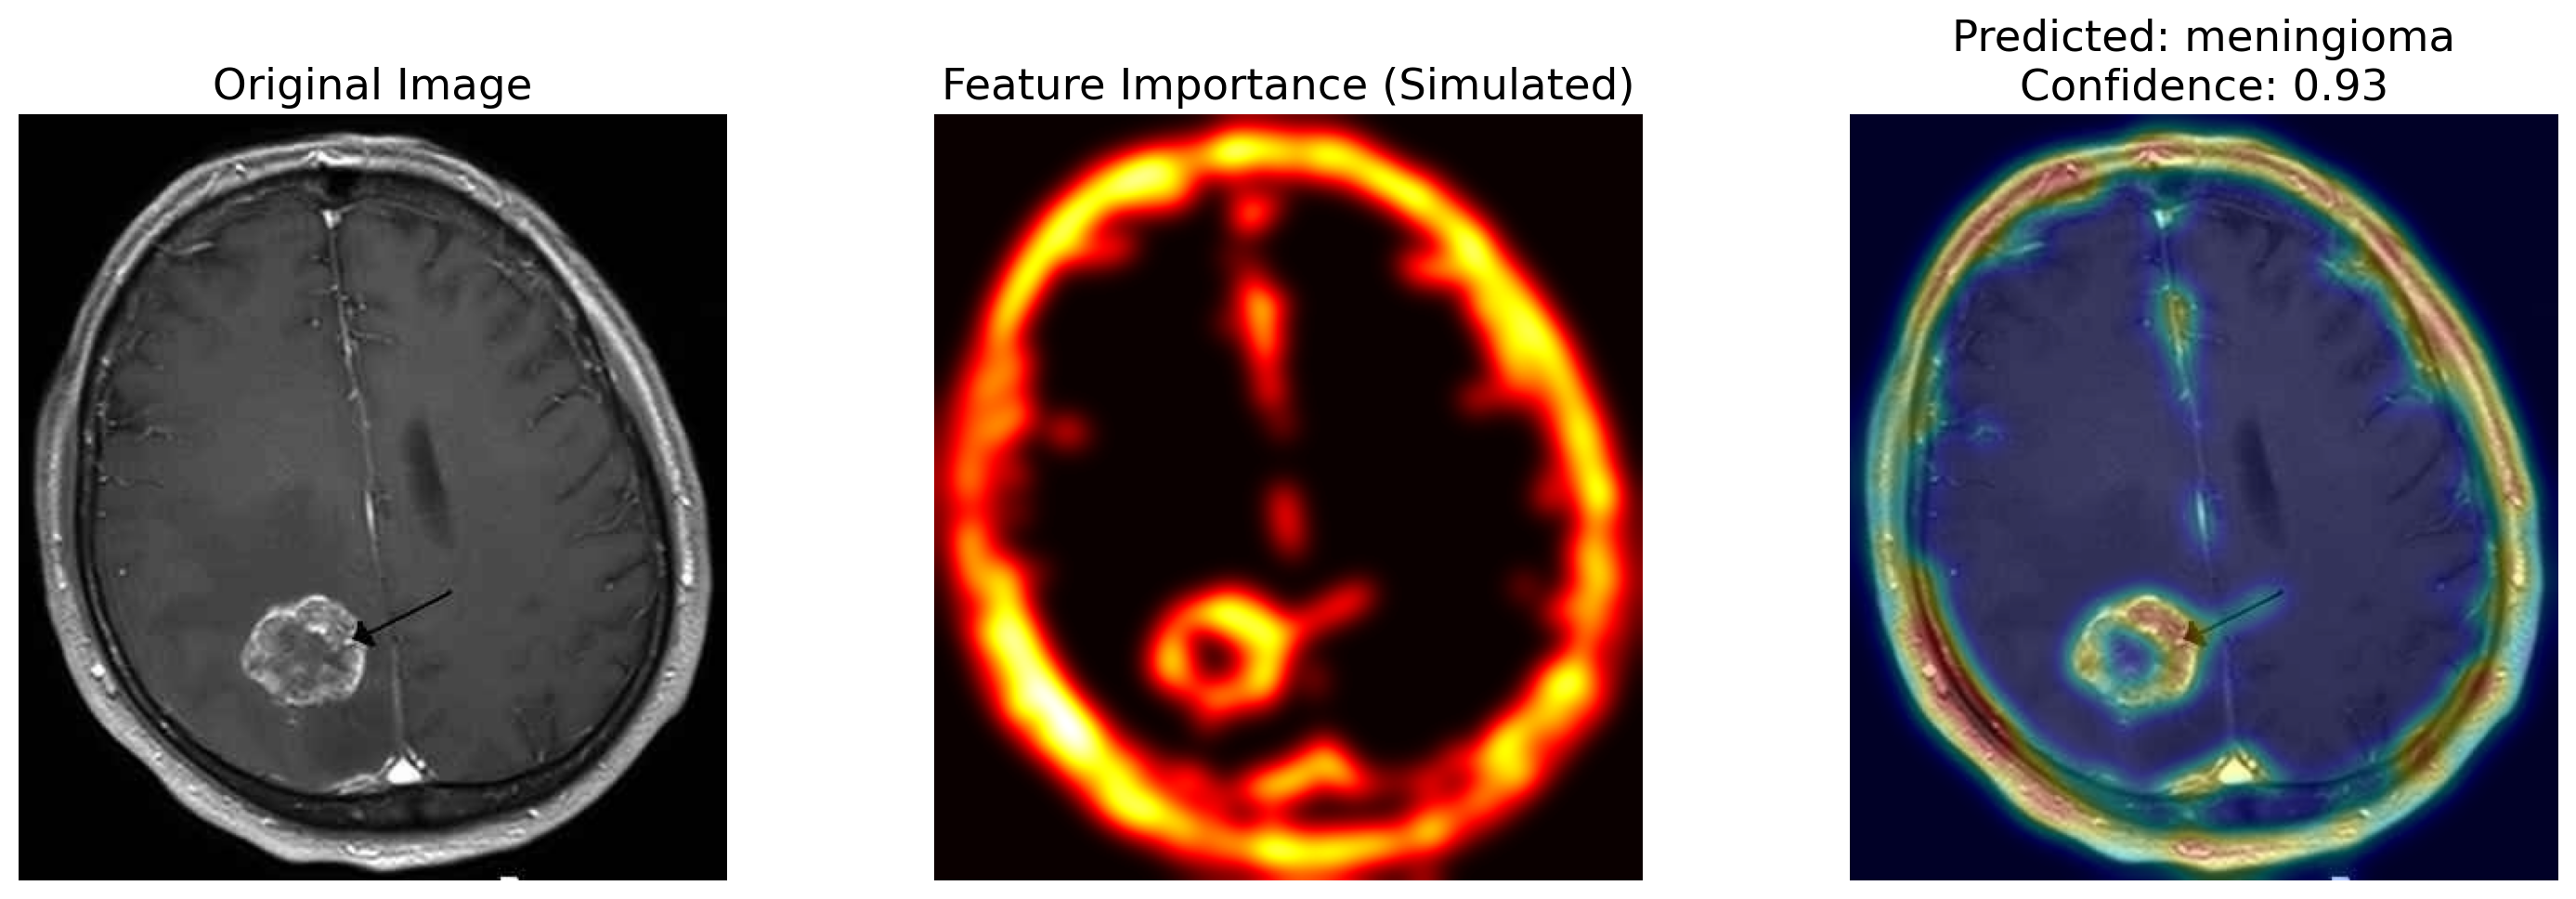

In [ ]:
image_size = (150, 150)
try:
    print(f"Trying size: {image_size}")
    predicted_class, confidence, original_img = predict_with_custom_size(
        model,
        './download.jpg',
        target_size=image_size,
        class_names=class_indices_train_list
    )

    print(f"Success! Predicted: {predicted_class} with confidence: {confidence:.2f}")

    # Create visualization
    gradcam_image = manual_gradcam_visualization(original_img, predicted_class, confidence)
except Exception as e:
    print(f"Size {image_size} failed: {e}")